In [7]:
import numpy as np 
import matplotlib.pyplot as plt

[[0.84863173 0.29216831]
 [0.71921305 0.8380155 ]
 [0.99598344 0.30749751]
 [0.10458713 0.37453009]
 [0.55914244 0.71051683]
 [0.53935126 0.13630197]
 [0.68231439 0.14644503]
 [0.56517071 0.34665337]
 [0.54350703 0.0108886 ]
 [0.74306221 0.50619048]]
[0.84863173 0.29216831]


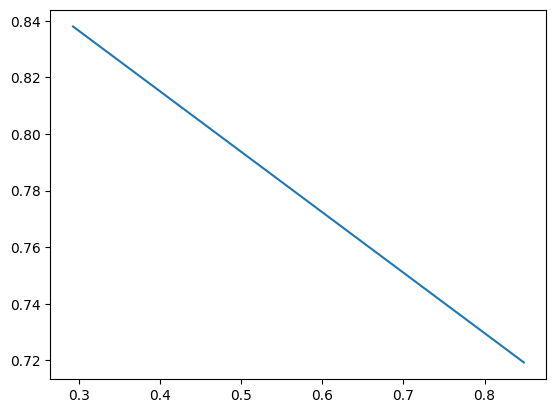

In [11]:
values = np.random.random((2, 10))
print(values)
print(values[0])
plt.plot(values[:][0], values[:][1])